In [1]:
import pandas as pd
import datetime
import requests
import json
import sys, os
import itertools
import time
import numpy as np
from os import path
from pathlib import Path
from binance.spot import Spot
from twelvedata import TDClient
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import itertools
import xgboost as xgb
import seaborn as sns
from typing import Union, Dict, List
import talib
import ta
import shap
sys.path.insert(0, os.path.join(os.getcwd(), ".."))
import fin_utilities 
cfg = fin_utilities.__cfg_reading("pred")
import my_functions

import matplotlib as mpl
# Set the default color cycle
mpl.rcParams.update(mpl.rcParamsDefault)


#td = TDClient(apikey=cfg['TWELVEDATA']['API'])  

PROJECT_DIR = eval(cfg['PROJECT_PATH'])
DATA_PATH   = PROJECT_DIR / cfg['DATA_FOLDER']
SOURCE      = cfg['API_DATA_SOURCE']
URL         = cfg[SOURCE]['API_URL_HIST_DATA']
COLUMNS     = cfg[SOURCE]['COLUMN_NAMES']
PARAMS      = cfg[SOURCE]['REQ_PARAMS']
PAIR        = cfg['SYMBOL'] + cfg['STABLECOIN']
MAX_LENGTH  = cfg['MAX_TRADE_DURATION']
XGB_PARAM   = cfg['xgb']


In [2]:
if SOURCE == 'BINANCE':
    PARAMS.update({'startTime': my_functions.datetime_to_ts(PARAMS['startTime'])})
    PARAMS.update({'endTime': my_functions.datetime_to_ts(PARAMS['endTime'])})

PARAMS  

limit=1000

In [3]:
compare_other_symbols = True
# new_connection
client = Spot()

df = my_functions.load_data(client, PAIR, DATA_PATH, PARAMS, COLUMNS)


if compare_other_symbols:

    pairs_available = my_functions.get_all_pairs_available(client)

    # prendo le top coin e rimuovo il simbolo in cfg se c'è
    symbols, actualized_mc = my_functions.get_top_symbols_by_marketcap(50, cfg['STABLECOIN'])
    symbols = [el for el in symbols if el not in PAIR]

    for s in symbols:

        if s in pairs_available:
            
            df = pd.concat([df,my_functions.load_data(client, s, DATA_PATH, PARAMS, COLUMNS)], ignore_index=True)


Loading BTCUSDT_1d.csv.
Loading ETHUSDT_1d.csv.
Loading BNBUSDT_1d.csv.
Loading XRPUSDT_1d.csv.
Loading ADAUSDT_1d.csv.
Loading DOGEUSDT_1d.csv.
Loading MATICUSDT_1d.csv.
Loading SOLUSDT_1d.csv.
Loading DOTUSDT_1d.csv.
Loading SHIBUSDT_1d.csv.
Loading LTCUSDT_1d.csv.
Loading AVAXUSDT_1d.csv.
Loading TRXUSDT_1d.csv.
Loading DAIUSDT_1d.csv.
Loading UNIUSDT_1d.csv.
Loading ATOMUSDT_1d.csv.
Loading LINKUSDT_1d.csv.
Loading XMRUSDT_1d.csv.
Loading ETCUSDT_1d.csv.
Loading APTUSDT_1d.csv.
Loading BCHUSDT_1d.csv.
Loading XLMUSDT_1d.csv.
Loading APEUSDT_1d.csv.
Loading QNTUSDT_1d.csv.
Loading NEARUSDT_1d.csv.
Loading FILUSDT_1d.csv.
Loading LDOUSDT_1d.csv.
Loading ALGOUSDT_1d.csv.
Loading VETUSDT_1d.csv.
Loading HBARUSDT_1d.csv.
Loading ICPUSDT_1d.csv.
Loading MANAUSDT_1d.csv.
Loading FTMUSDT_1d.csv.
Loading AXSUSDT_1d.csv.
Loading AAVEUSDT_1d.csv.
Loading EOSUSDT_1d.csv.
Loading SANDUSDT_1d.csv.
Loading EGLDUSDT_1d.csv.
Loading FLOWUSDT_1d.csv.
Loading THETAUSDT_1d.csv.


In [4]:
df.drop(columns=['OpenTimestamp', 'Ignore.'], inplace=True, errors='ignore')
df['Mkt_Cap'] = df['Close']*df['Volume']

df_mkt_cap = df.groupby(['CloseTimestamp'])['Mkt_Cap'].sum().reset_index()
df_mkt_cap.head(5)

,CloseTimestamp,Mkt_Cap
0,2017-08-18 01:59:59.999,5.530558e+06
1,2017-08-19 01:59:59.999,7.733330e+06
2,2017-08-20 01:59:59.999,2.202965e+06
3,2017-08-21 01:59:59.999,2.659419e+06
4,2017-08-22 01:59:59.999,4.465435e+06


In [5]:
df

,Open,High,Low,Close,Volume,CloseTimestamp,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Symbol,Mkt_Cap
0,4261.480,4485.390,4200.740,4285.080,7.951504e+02,2017-08-18 01:59:59.999,3.454770e+06,3427,6.162485e+02,2.678216e+06,BTCUSDT,3.407283e+06
1,4285.080,4371.520,3938.770,4108.370,1.199888e+03,2017-08-19 01:59:59.999,5.086958e+06,5233,9.728687e+02,4.129123e+06,BTCUSDT,4.929585e+06
2,4108.370,4184.690,3850.000,4139.980,3.813098e+02,2017-08-20 01:59:59.999,1.549484e+06,2153,2.743360e+02,1.118002e+06,BTCUSDT,1.578615e+06
3,4120.980,4211.080,4032.620,4086.290,4.670830e+02,2017-08-21 01:59:59.999,1.930364e+06,2321,3.767959e+02,1.557401e+06,BTCUSDT,1.908637e+06
4,4069.130,4119.620,3911.790,4016.000,6.917431e+02,2017-08-22 01:59:59.999,2.797232e+06,3972,5.573561e+02,2.255663e+06,BTCUSDT,2.778040e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
44938,0.751,0.762,0.731,0.760,2.798037e+06,2023-01-07 00:59:59.999,2.084590e+06,9416,1.256501e+06,9.362066e+05,THETAUSDT,2.126508e+06
44939,0.760,0.770,0.759,0.769,1.749199e+06,2023-01-08 00:59:59.999,1.338107e+06,7792,8.838458e+05,6.763375e+05,THETAUSDT,1.345134e+06
44940,0.769,0.799,0.759,0.794,2.478193e+06,2023-01-09 00:59:59.999,1.922311e+06,10208,1.101766e+06,8.556529e+05,THETAUSDT,1.967686e+06
44941,0.794,0.830,0.791,0.803,7.799547e+06,2023-01-10 00:59:59.999,6.327888e+06,24049,3.365247e+06,2.732104e+06,THETAUSDT,6.263036e+06


In [6]:
df_btc = pd.merge(df[df['Symbol']==PAIR], df_mkt_cap, on='CloseTimestamp', suffixes=[None, '_tot'])
df_btc.drop(columns=['Symbol', 'Quote asset volume','Taker buy base asset volume','Taker buy quote asset volume'], inplace=True)
df_btc['CloseTimestamp'] = df_btc['CloseTimestamp'].dt.date
df_btc.head(5)

,Open,High,Low,Close,Volume,CloseTimestamp,Number of trades,Mkt_Cap,Mkt_Cap_tot
0,4261.48,4485.39,4200.74,4285.08,795.150377,2017-08-18,3427,3.407283e+06,5.530558e+06
1,4285.08,4371.52,3938.77,4108.37,1199.888264,2017-08-19,5233,4.929585e+06,7.733330e+06
2,4108.37,4184.69,3850.00,4139.98,381.309763,2017-08-20,2153,1.578615e+06,2.202965e+06
3,4120.98,4211.08,4032.62,4086.29,467.083022,2017-08-21,2321,1.908637e+06,2.659419e+06
4,4069.13,4119.62,3911.79,4016.00,691.743060,2017-08-22,3972,2.778040e+06,4.465435e+06


In [7]:
df_btc['Norm_wgt_vol'] = df['Volume']*(df_btc['Open']+df_btc['High']+df_btc['Low']+df_btc['Close'])/(4*df_btc['Number of trades'])

15 2


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.



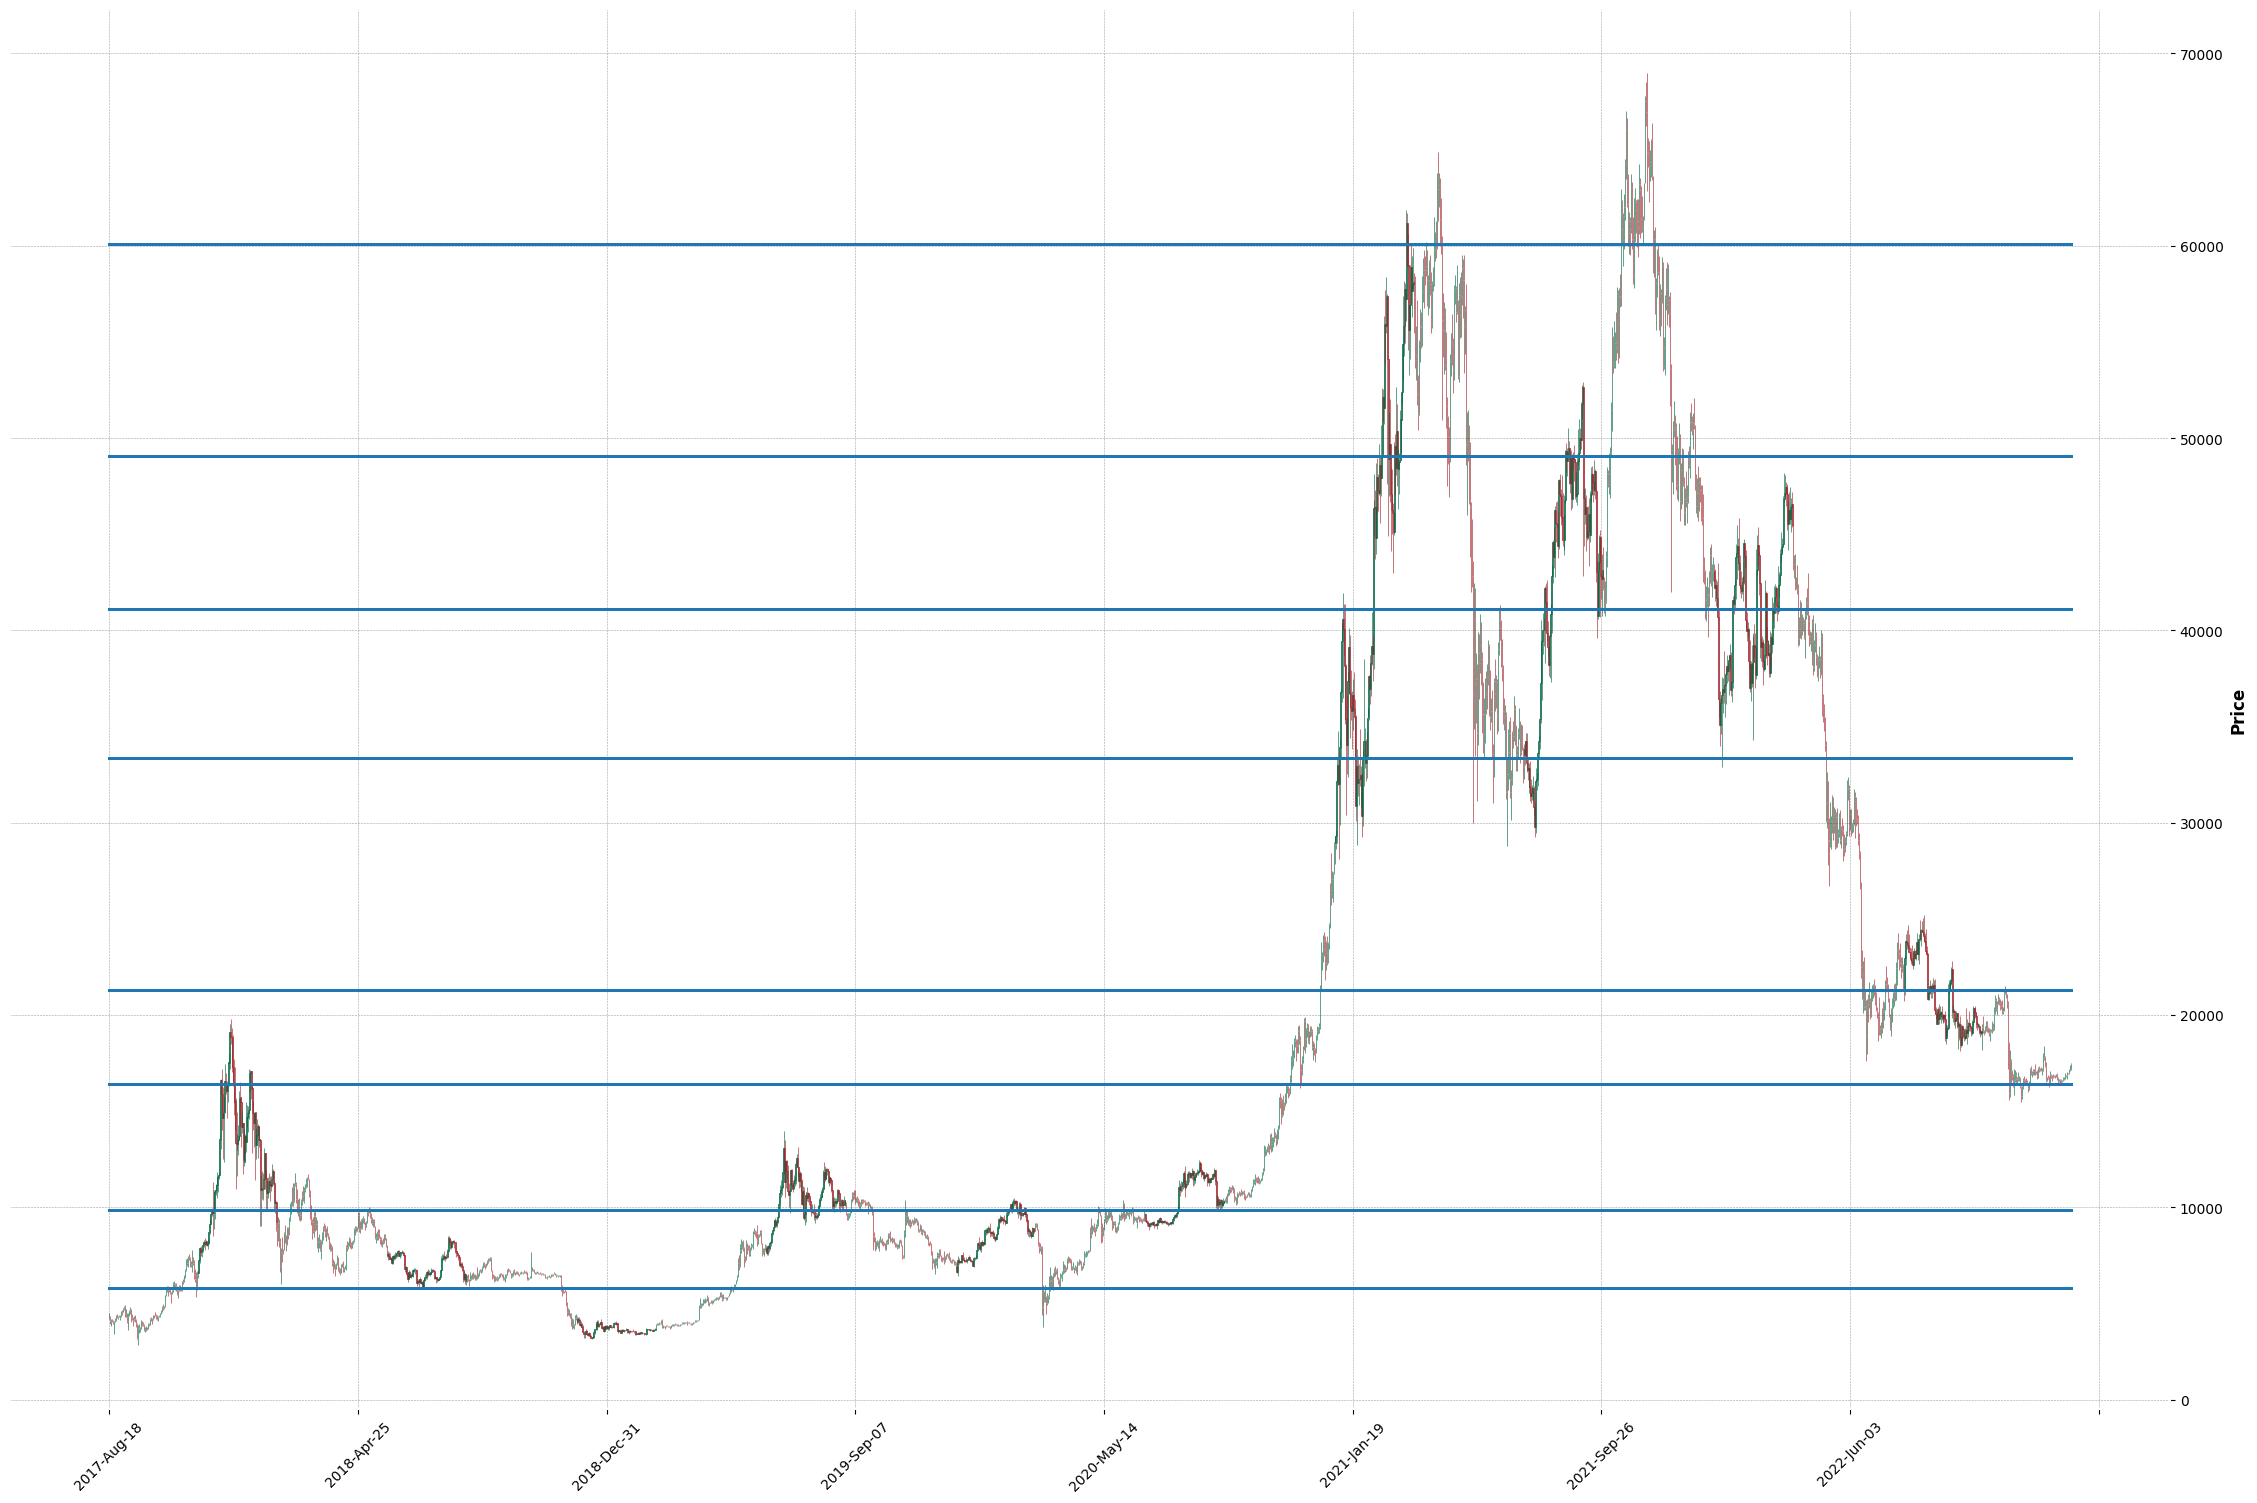

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import mplfinance as mpf

# get levels using the first method
levels_1 = my_functions.detect_level_method_1(df_btc)
# get levels using the second method
levels_2 = my_functions.detect_level_method_2(df_btc)



def plot_candlestick_aline(df_, width, height, support,resistance):
    """
    Plot candlestick chart of the dataframe
    """
    dict(hlines=[support,resistance],colors=['g','r'],linestyle='-.')
    df = df_.copy()
    df.rename(columns={df.columns[0]:'Date'}, inplace=True)
    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]])
    df=df.set_index(df.columns[0])
    mpf.plot(df,type='candle', style='charles', figsize=(width, height),alines=dict(alines=support,linestyle='-.'))

def plot_candlestick_hline(df_, width, height, supports,resistance):
    """
    Plot candlestick chart of the dataframe
    """
    df = df_.copy()
    df.rename(columns={df.columns[0]:'Date'}, inplace=True)
    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]])
    df=df.set_index(df.columns[0])
    mpf.plot(df,type='candle', style='charles', figsize=(width, height), hlines=list(supports))

def determine_optimal_clusters(data, max_clusters, plot=False):
    """
    Determines the optimal number of clusters for a given dataset using the elbow method.
    """

    wcss = []
    silhouette_scores = []

    # Loop through a range of possible number of clusters
    for i in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init=5, random_state=42)
        labels = kmeans.fit_predict(data)
        silhouette_scores.append(silhouette_score(data, labels))
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)


    # Find the "elbow" point on the plot
    kneed_clusters = None
    for i in range(2, len(wcss)):
        if wcss[i] - wcss[i-1] < wcss[i-1] - wcss[i-2]:
            kneed_clusters = i
            break

    optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
    
    if plot:
        # Plot the within-cluster variation for each number of clusters
        plt.plot(range(2, max_clusters+1), wcss)
        plt.title('Elbow Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('Within-cluster variation')
        plt.show()

        plt.plot(range(2, max_clusters+1), silhouette_scores)
        plt.title('Silhouette Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette Score')
        plt.show()

    return kneed_clusters, optimal_clusters

    


# determine the optimal number of clusters
kneed, silhouette = determine_optimal_clusters(df_btc[['High','Low','Norm_wgt_vol']],20, False)
print(kneed, silhouette)

# fit KMeans to the data using the optimal number of clusters
kmeans = KMeans(n_clusters=int((kneed+silhouette)/2))
kmeans.fit(df_btc[['High','Low','Norm_wgt_vol']])
pred_y = kmeans.fit_predict(df_btc[['High','Low','Norm_wgt_vol']])

# Extract the cluster centers
cluster_centers = kmeans.cluster_centers_
df_btc['Cluster'] = pred_y

# Use the cluster centers as support and resistance levels
supports = cluster_centers[:, 0]
resistance = cluster_centers[:, 0]

#support = my_functions.list_of_tuple_to_hline(levels_2,df_btc['CloseTimestamp'])
plot_candlestick_hline(df_btc[['CloseTimestamp','Open','High','Low','Close']], 30,20,supports, None)

In [19]:
df_btc['EMA_VOL_7d'] = my_functions.rolling_kpi(df_btc,'Volume',7, 'ema', False)
df_btc['EMA_VOL_30d'] = df_btc['Volume'].ewm(span=30, adjust=False).mean()
df_btc['EMA_VOL_60d'] = df_btc['Volume'].ewm(span=60, adjust=False).mean()
df_btc['EMA_VOL_100d'] = df_btc['Volume'].ewm(span=100, adjust=False).mean()
df_btc['EMA_VOL_200d'] = df_btc['Volume'].ewm(span=200, adjust=False).mean()
df_btc['STD_VOL_7d'] = my_functions.rolling_kpi(df_btc,'Volume',7, 'std', False)
df_btc['STD_VOL_30d'] = my_functions.rolling_kpi(df_btc,'Volume',30, 'std', False)
df_btc['STD_VOL_60d'] = my_functions.rolling_kpi(df_btc,'Volume',60, 'std', False)
df_btc['STD_VOL_100d'] = my_functions.rolling_kpi(df_btc,'Volume',100, 'std', False)
df_btc['STD_VOL_200d'] = my_functions.rolling_kpi(df_btc,'Volume',200, 'std', False)
df_btc['PCT_Change'] = df_btc['Close'].pct_change()
# Calculate the mean and standard deviation of the daily returns
mean_return = df_btc['PCT_Change'].mean()
std_return = df_btc['PCT_Change'].std()
# Calculate the risk-free rate
risk_free_rate = 0.01
# Calculate the Sharpe ratio
df_btc['Sharpe_Ratio'] = (mean_return - risk_free_rate) / std_return
df_btc['Log_Ret'] = np.log(1 + df_btc['PCT_Change'])
df_btc['Log_Ret_7d'] = np.log(df_btc['PCT_Change']) - np.log(df_btc['PCT_Change'].shift(7))
df_btc['Excursion'] = df_btc['High']-df_btc['Low']
df_btc['PCT_Excursion'] = df_btc['Excursion'].pct_change()
df_btc['AVG_Candle_Price'] = (df_btc['Open']+df_btc['High']+df_btc['Low']+df_btc['Close'])/4
df_btc['AVG_Candle_Price_7d'] = df_btc['AVG_Candle_Price'].ewm(span=7, adjust=False).mean()
df_btc['AVG_Candle_Price_30d'] = df_btc['AVG_Candle_Price'].ewm(span=30, adjust=False).mean()
df_btc['AVG_Candle_Price_60d'] = df_btc['AVG_Candle_Price'].ewm(span=60, adjust=False).mean()
df_btc['AVG_Candle_Price_100d'] = df_btc['AVG_Candle_Price'].ewm(span=100, adjust=False).mean()
df_btc['AVG_Candle_Price_200d'] = df_btc['AVG_Candle_Price'].ewm(span=200, adjust=False).mean()
df_btc['STD_AVG_Candle_Price_7d'] = my_functions.rolling_kpi(df_btc,'AVG_Candle_Price',7, 'std', False)
df_btc['STD_AVG_Candle_Price_30d'] = my_functions.rolling_kpi(df_btc,'AVG_Candle_Price',30, 'std', False)
df_btc['STD_AVG_Candle_Price_60d'] = my_functions.rolling_kpi(df_btc,'AVG_Candle_Price',60, 'std', False)
df_btc['STD_AVG_Candle_Price_100d'] = my_functions.rolling_kpi(df_btc,'AVG_Candle_Price',100, 'std', False)
df_btc['STD_AVG_Candle_Price_200d'] = my_functions.rolling_kpi(df_btc,'AVG_Candle_Price',200, 'std', False)
df_btc['PCT_Mkt_Cap'] = df_btc['Mkt_Cap']/df_btc['Mkt_Cap_tot']
df_btc['DELTA_NTrades'] = df_btc['Number of trades']- df_btc['Number of trades'].shift()
df_btc['EMA_Trades_7d'] = my_functions.rolling_kpi(df_btc,'Number of trades',7, 'mean', False)
df_btc['EMA_Trades_30d'] = my_functions.rolling_kpi(df_btc,'Number of trades',30, 'mean', False)
df_btc['EMA_Trades_60d'] = my_functions.rolling_kpi(df_btc,'Number of trades',60, 'mean', False)
df_btc['EMA_Trades_100d'] = my_functions.rolling_kpi(df_btc,'Number of trades',100, 'mean', False)
df_btc['EMA_Trades_200d'] = my_functions.rolling_kpi(df_btc,'Number of trades',200, 'mean', False)
#Volume-price trend:
df_btc['VP_trend'] = df_btc['Volume'] * df['Close'].pct_change()
#On-balance volume
df_btc['OBV'] = np.where(df_btc['Close'] > df_btc['Close'].shift(1), df_btc['Volume'], - df_btc['Volume'])
df_btc['OBV'] = df_btc['OBV'].cumsum()
#VWAP
df_btc['VWAP'] = (df_btc['Close'] * df_btc['Volume']).cumsum() / df_btc['Volume'].cumsum()
#Volume Rate Of Change
df_btc['Volume_ROC'] = df_btc['Volume'].pct_change()
#Volume-price trend divergence:
df_btc['VP_divergence'] = df_btc['Volume'].rolling(window=10).mean() - df_btc['Close'].rolling(window=10).mean()
#Chaikin Money Flow
df_btc["chaikin_money_flow"] = ((df_btc['Close'] - df_btc['Low']) - (df_btc['High'] - df_btc['Close'])) / (df_btc['High'] - df_btc['Low']) * df_btc['Volume']
# Head and Shoulders
#df_btc['hs_pattern'] = ta.pattern.head_and_shoulders(df['Close'],neck_width=1,trend='down')
# 2 crows or 3 black crows candlestick pattern 
#df_btc['cdl2crows'] = talib.CDL2CROWS(df_btc['Open'],df_btc['High'],df_btc['Low'],df_btc['Close'])
#df_btc['cdl3blackcrows'] = talib.CDL3BLACKCROWS(df_btc['Open'],df_btc['High'],df_btc['Low'],df_btc['Close'])
df_btc['MAX_50d'] = my_functions.rolling_kpi(df_btc,'High',50, 'max', False)
df_btc['MIN_50d'] = my_functions.rolling_kpi(df_btc,'Low',50, 'min', False)
# RSI
df_btc['RSI'] = ta.momentum.RSIIndicator(df_btc['Close'], window=14).rsi()
#BollingerBands
bb = ta.volatility.BollingerBands(df_btc['Close'], window=20, window_dev=2)
df_btc['BB_upper'] = bb.bollinger_hband()
df_btc['BB_lower'] = bb.bollinger_lband()
#MFI
mfi = ta.volume.MFIIndicator(df_btc['High'], df_btc['Low'], df_btc['Close'], df_btc['Volume'], window=14)
df_btc['MFI'] = mfi.money_flow_index()

invalid value encountered in log


In [20]:
#df_btc = labelize_output_according_criterion(df_btc, ['Open','High','Low','Close'], max_trade_length=MAX_LENGTH)
df_btc = my_functions.labelize_output_according_criterion2(df_btc, ['Open','High','Low','Close'], max_trade_length=MAX_LENGTH)
df_btc['signal'] = (df_btc['min_above'].lt(df_btc['min_below'])) & (df_btc['min_above'] <= MAX_LENGTH)
df_btc['signal']=df_btc['signal'].astype(int)
df_btc.tail(10)


,Open,High,Low,Close,Volume,CloseTimestamp,Number of trades,Mkt_Cap,Mkt_Cap_tot,Norm_wgt_vol,...,MIN_50d,RSI,BB_upper,BB_lower,MFI,signal,TP,SL,min_above,min_below
1963,16541.77,16628.00,16499.01,16616.75,96925.41374,2023-01-02,3218355,1.610585e+09,2.089535e+09,499.071142,...,15476.00,44.317817,17580.014641,16128.132359,46.282722,0,17115.2525,16367.49875,5.0,5.0
1964,16617.17,16799.23,16548.70,16672.87,121888.57191,2023-01-03,4036118,2.032232e+09,3.195584e+09,503.107627,...,15476.00,45.787303,17392.199125,16205.764875,53.225292,0,17173.0561,16422.77695,5.0,5.0
1965,16672.78,16778.40,16605.28,16675.18,159541.53733,2023-01-04,5097596,2.660384e+09,3.686158e+09,522.131826,...,15476.00,45.850650,17117.520971,16367.646029,51.137202,0,17175.4354,16425.05230,5.0,5.0
1966,16675.65,16991.87,16652.66,16850.36,220362.18862,2023-01-05,6310703,3.713182e+09,5.403677e+09,586.378697,...,15476.00,50.567878,16972.238801,16462.330199,52.632767,0,17355.8708,16597.60460,5.0,5.0
1967,16850.36,16879.82,16753.00,16831.85,163473.56641,2023-01-06,4842014,2.751563e+09,3.846900e+09,568.163786,...,15476.00,50.071524,16983.741715,16470.800285,52.933626,1,17336.8055,16579.37225,4.0,5.0
1968,16831.85,17041.00,16679.00,16950.65,207401.28415,2023-01-07,5388661,3.515587e+09,4.836451e+09,649.516883,...,15476.00,53.243658,17009.781367,16462.173633,53.971608,1,17459.1695,16696.39025,4.0,5.0
1969,16950.31,16981.91,16908.00,16943.57,104526.56880,2023-01-08,3227161,1.771053e+09,2.403182e+09,548.873064,...,15476.00,53.027433,17034.628514,16457.862486,54.080840,1,17451.8771,16689.41645,3.0,5.0
1970,16943.83,17176.99,16911.00,17127.83,135155.89695,2023-01-09,4036092,2.314927e+09,3.466963e+09,570.612528,...,15476.00,57.827520,17078.425896,16482.960104,60.215091,0,17641.6649,16870.91255,5.0,5.0
1971,17127.83,17398.80,17104.66,17178.26,266211.52723,2023-01-10,6327667,4.573051e+09,7.413332e+09,723.722321,...,15476.00,59.060593,17136.615512,16453.040488,62.791586,0,17693.6078,16920.58610,5.0,5.0
1972,17179.04,17495.69,17146.34,17469.55,200416.33885,2023-01-11,4871401,3.501183e+09,5.301638e+09,712.678569,...,15616.63,65.360727,17278.217040,16375.926960,70.819579,0,17993.6365,17207.50675,NaN,NaN


In [21]:
df_btc.to_csv('test.csv', index=False)

In [22]:
dt_threshold = df_btc.iloc[-100]['CloseTimestamp']

df_btc.drop(columns=['CloseAbovethreshold', 'HighAbovethreshold',
       'LowAbovethreshold', 'OpenAbovethreshold', 'CloseBelowthreshold',
       'HighBelowthreshold', 'LowBelowthreshold', 'OpenBelowthreshold', 'TP',
       'SL', 'min_above', 'min_below'], inplace=True, errors='ignore')
train, test = my_functions.split_train_validation(df_btc,'CloseTimestamp', dt_threshold )
train.drop(columns=['CloseTimestamp'], inplace=True)
test.drop(columns=['CloseTimestamp'], inplace=True)




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.



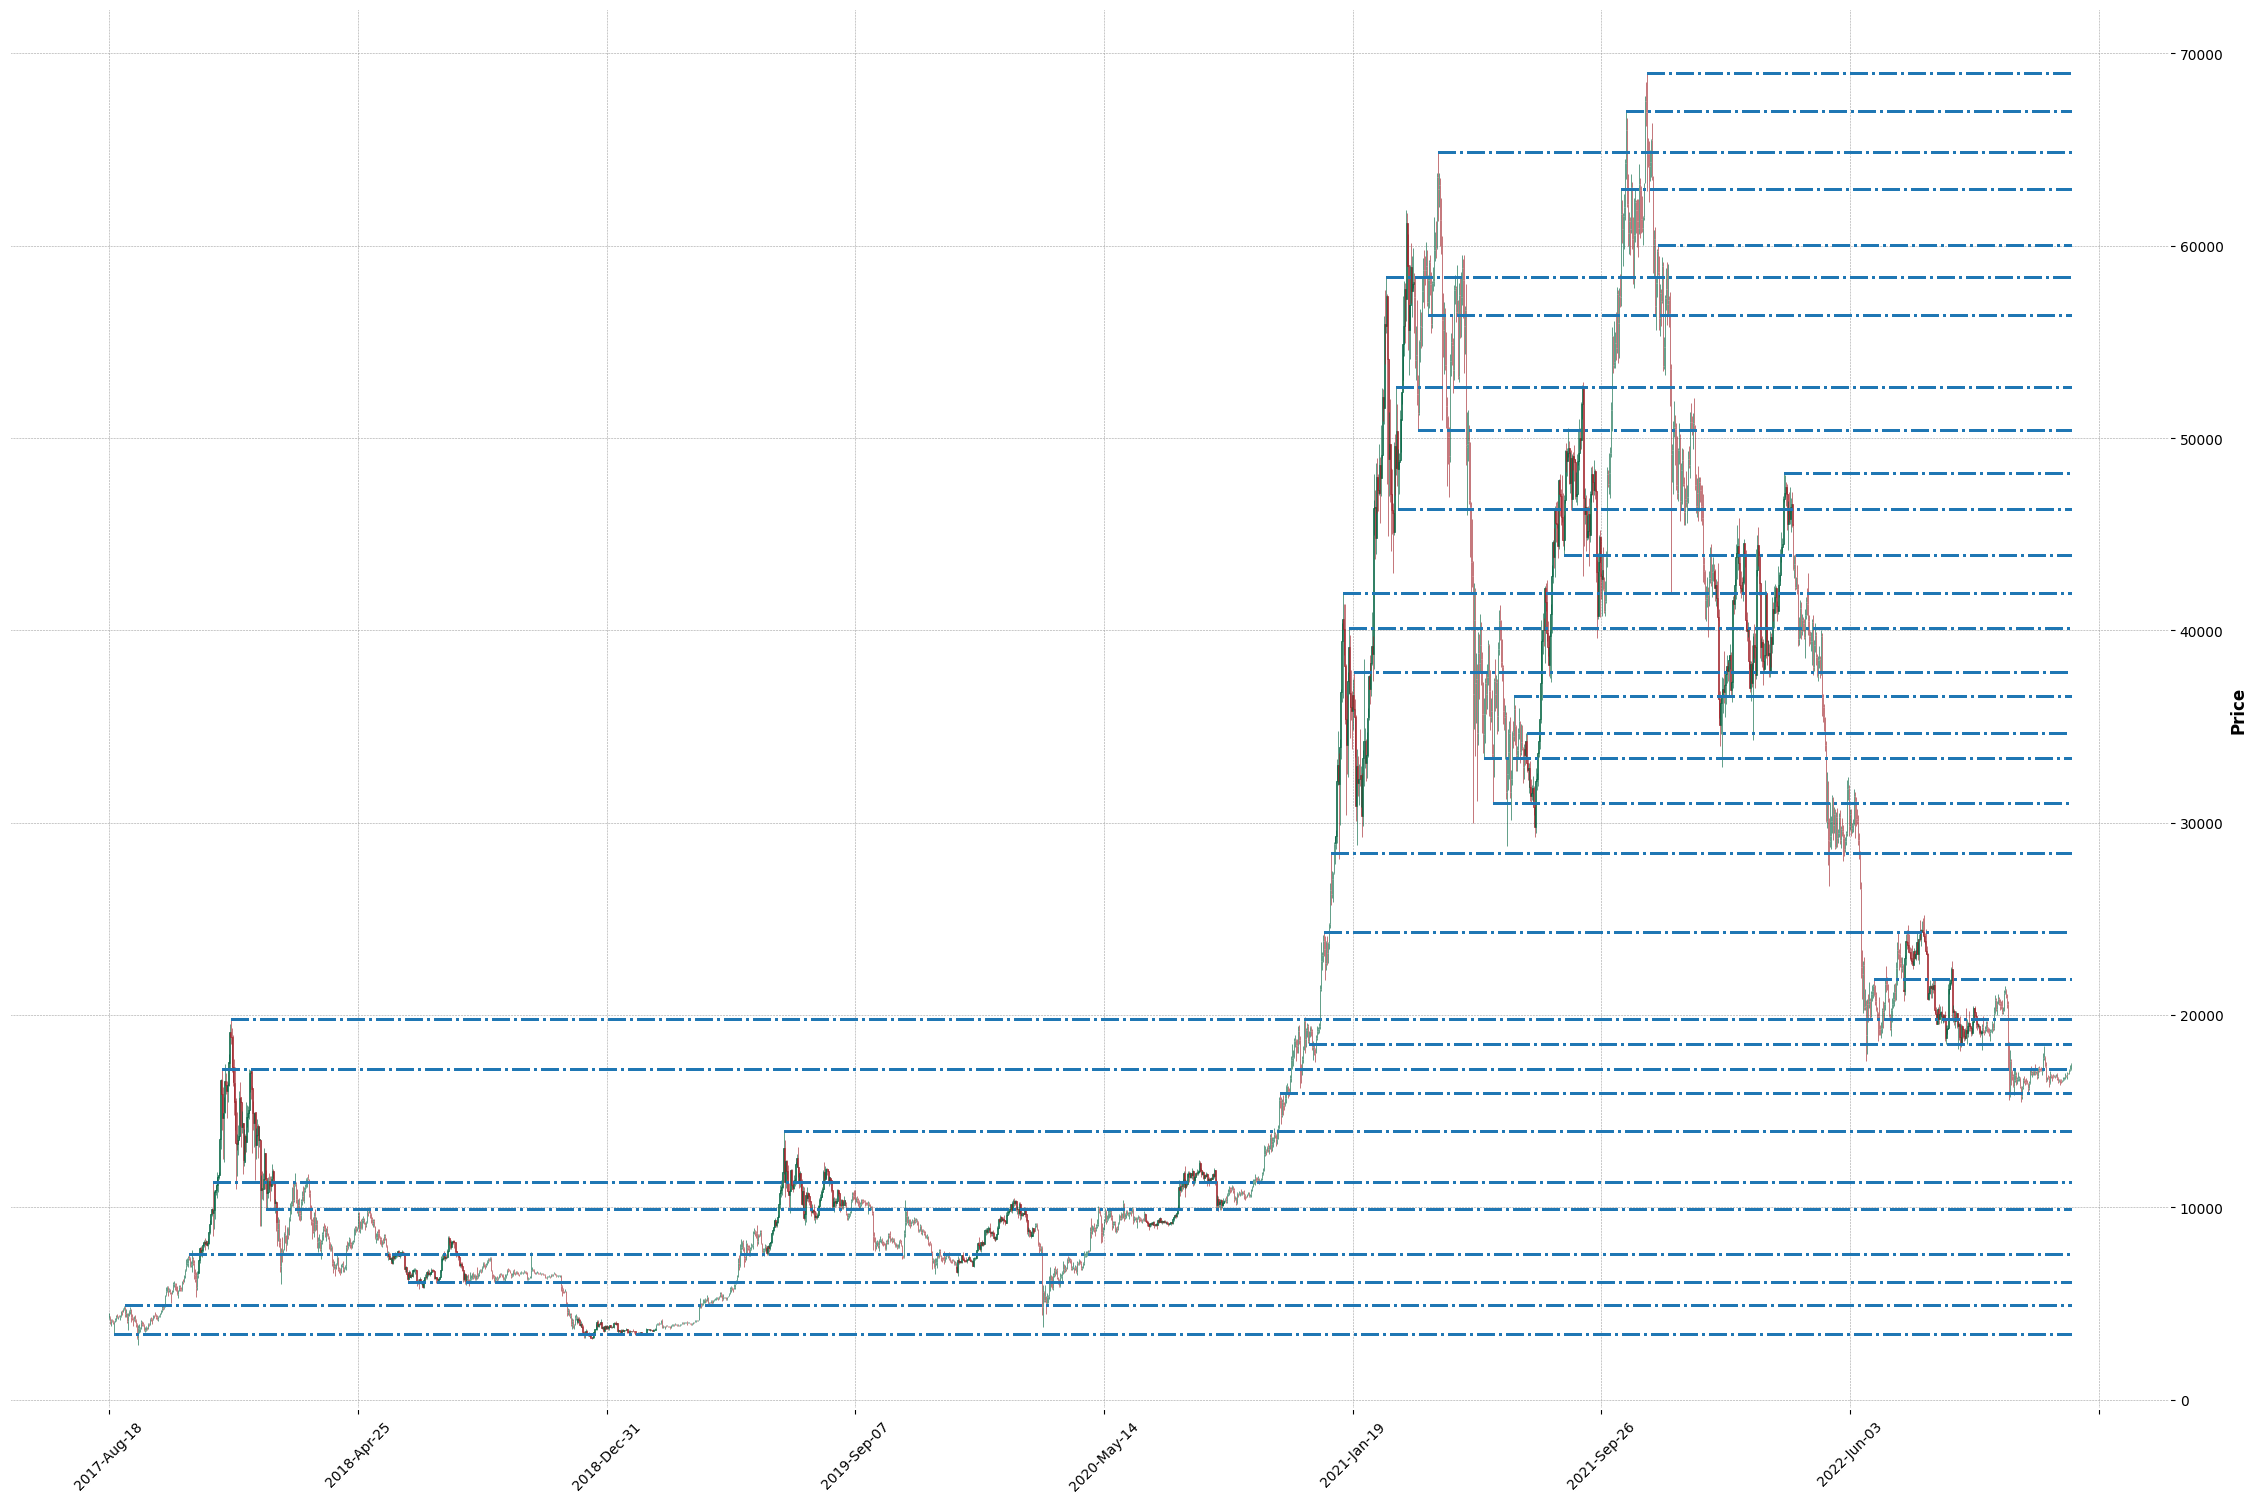

In [23]:
# get levels using the first method
levels_1 = my_functions.detect_level_method_1(df_btc)
# get levels using the second method
levels_2 = my_functions.detect_level_method_2(df_btc)

import mplfinance as mpf


def plot_candlestick(df_, width, height, support,resistance):
    """
    Plot candlestick chart of the dataframe
    """
    dict(hlines=[support,resistance],colors=['g','r'],linestyle='-.')
    df = df_.copy()
    df.rename(columns={df.columns[0]:'Date'}, inplace=True)
    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]])
    df=df.set_index(df.columns[0])
    mpf.plot(df,type='candle', style='charles', figsize=(width, height),alines=dict(alines=support,linestyle='-.'))


support = my_functions.list_of_tuple_to_hline(levels_1,df_btc['CloseTimestamp'])

plot_candlestick(df_btc[['CloseTimestamp','Open','High','Low','Close']], 30,20,support, 'asd')



In [31]:
tscv = TimeSeriesSplit(gap=0, max_train_size=150, n_splits=35, test_size=50)
p = {  
    'eval_metric':'auc',
    'tree_method':'hist',
    'lambda':2,
    'max_depth':5,
    'scale_pos_weight':3,
    'objective':'reg:squaredlogerror',
    'colsample_bytree': .7,
    'eta':0.01,
    'n_estimators':3000
    }

model = my_functions.model_selection('xgb',p)
print(model.get_params())
for train_index, val_index in tscv.split(train):
    print(f'Train index:{train_index[0]}:{train_index[-1]}, Val index:{val_index[0]}:{val_index[-1]}')
    train_features, train_labels    = my_functions.split_target_features(train.loc[train_index],cfg['TARGET_VARIABLE'])
    val_features, val_labels        = my_functions.split_target_features(train.loc[val_index],cfg['TARGET_VARIABLE'])
    model.fit(train_features, train_labels)
    print("Test set score: {:.2f}".format(model.score(val_features, val_labels)))


{'objective': 'reg:squaredlogerror', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'auc', 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 3000, 'n_jobs': -1, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 3, 'subsample': None, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None, 'lambda': 2, 'eta': 0.01}
Train index:0:123, Val index:124:173
Test set score: 0.7

In [ ]:
def model_selection(
    model_type: str,
    parameter: Dict
) -> xgb.XGBClassifier:
    """
    Instantiate a tree based model
    
     Args:
        model_type: xgb/lgb currently supported
        parameter:  default parameters 
    
    Returns:
        Union[xgb.XGBClassifier, LGBMClassifier]: model instantiated
    """

    dict_model = {
            'xgb': xgb.XGBClassifier(n_jobs=-1, random_state=42)
        }

    return dict_model[model_type].set_params(**parameter)


tscv = TimeSeriesSplit(n_splits=15, test_size=100)
p = {  
    'eval_metric':'auc',
    'tree_method':'hist',
    'lambda':5,
    'gamma':2,
    'max_depth':7,
    'scale_pos_weight':2,
    'objective':'binary:logistic',
    #'subsample': .95,
    'colsample_bytree': .9,
    'min_child_weight':1,
    'eta':0.05,
    'n_estimators':2000
}

model = model_selection('xgb',p)


for train_index, test_index in tscv.split(train):
    print(f'Train index:{train_index[0]}:{train_index[-1]}, Val index:{test_index[0]}:{test_index[-1]}')
    train_features, train_labels    = my_functions.split_target_features(train.loc[train_index],cfg['TARGET_VARIABLE'])
    val_features, val_labels        = my_functions.split_target_features(train.loc[test_index],cfg['TARGET_VARIABLE'])
    X_train, X_test = train_features, val_features
    y_train, y_test = train_labels, val_labels

    model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose=500)
    

In [33]:
y_hat = model.predict_proba(train[train.columns[:-1]])[:,1]
y = train['signal']
df_test= pd.DataFrame({'y':y,'y_hat':y_hat})
df_test = pd.merge(train, df_test, left_index=True, right_index=True)
df_test = df_test[df_test.columns[1:]]
#df_test.sort_values(by=['y_hat'], ascending=False, inplace=True)
#df_test.reset_index(drop=True, inplace=True)
df_test

,High,Low,Close,Volume,Number of trades,Mkt_Cap,Mkt_Cap_tot,Norm_wgt_vol,Cluster,EMA_VOL_7d,...,chaikin_money_flow,MAX_50d,MIN_50d,RSI,BB_upper,BB_lower,MFI,signal,y,y_hat
0,4485.39,4200.74,4285.08,795.150377,3427,3.407283e+06,5.530558e+06,999.604607,2,795.150377,...,-323.954292,4485.39,4200.74,NaN,NaN,NaN,NaN,0,0,0.790846
1,4371.52,3938.77,4108.37,1199.888264,5233,4.929585e+06,7.733330e+06,957.511064,2,1026.429170,...,-259.386591,4485.39,3938.77,NaN,NaN,NaN,NaN,0,0,0.818588
2,4184.69,3850.00,4139.98,381.309763,2153,1.578615e+06,2.202965e+06,720.957051,2,747.458615,...,279.434239,4485.39,3850.00,NaN,NaN,NaN,NaN,0,0,0.848235
3,4211.08,4032.62,4086.29,467.083022,2321,1.908637e+06,2.659419e+06,827.657129,2,644.921256,...,-186.142242,4485.39,3850.00,NaN,NaN,NaN,NaN,0,0,0.856135
4,4119.62,3911.79,4016.00,691.743060,3972,2.778040e+06,4.465435e+06,701.693397,2,660.268736,...,1.963761,4485.39,3850.00,NaN,NaN,NaN,NaN,0,0,0.754522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1869,19645.52,18843.01,19591.51,406424.932560,5631615,7.962478e+09,1.024612e+10,1398.134922,7,421262.151228,...,351719.045761,25211.32,18125.98,48.044178,21833.839393,17757.189607,48.166352,0,0,0.687141
1870,20185.00,19155.36,19422.61,444322.953400,6254203,8.629911e+09,1.096996e+10,1391.634672,7,427027.351771,...,-213668.920347,25211.32,18125.98,46.581763,21540.689342,17827.766658,55.469747,0,0,0.637410
1871,19484.00,19159.42,19310.95,165625.139590,2470590,3.198379e+09,4.198064e+09,1296.813020,7,361676.798726,...,-10981.123310,25211.32,18125.98,45.593693,21137.303282,17979.560718,52.034294,0,0,0.613527
1872,19395.91,18920.35,19056.80,206812.470320,3320217,3.941184e+09,5.139767e+09,1194.159623,7,322960.716624,...,-88133.180324,25211.32,18125.98,43.340282,20297.913661,18485.056339,52.587703,1,1,0.550264


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


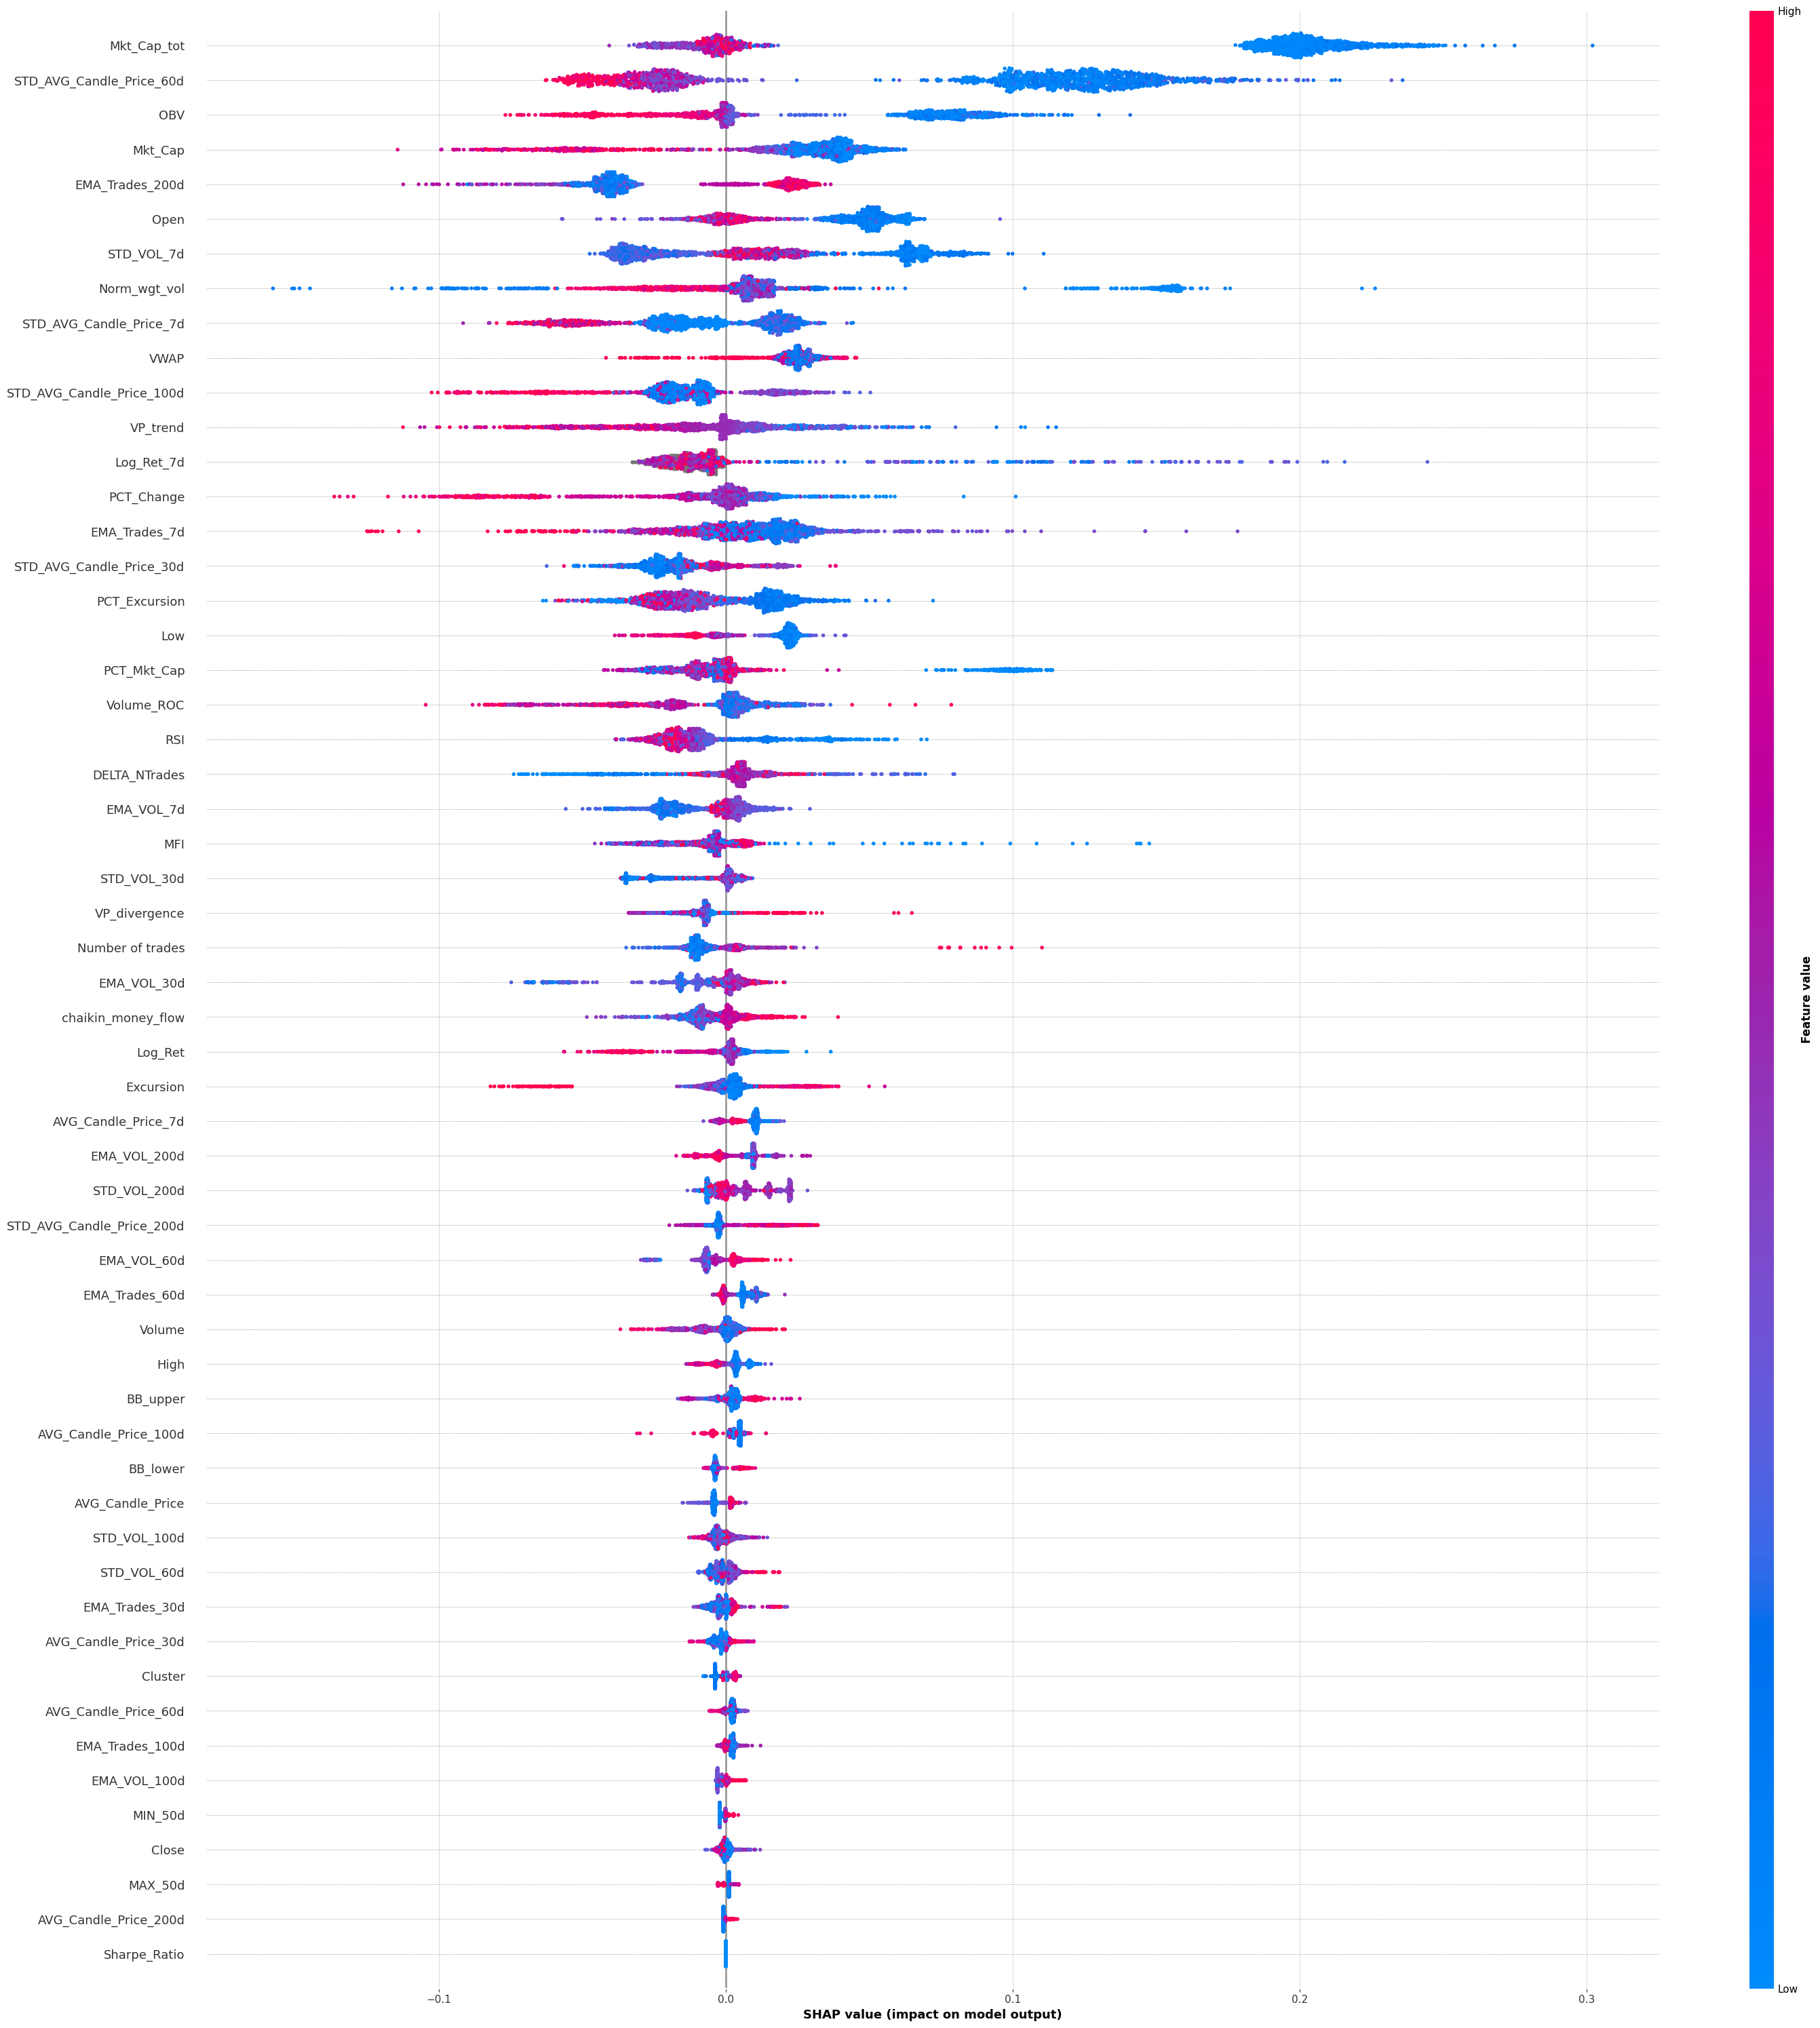

In [38]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train[train.columns[:-1]])
shap.summary_plot(shap_values, train[train.columns[:-1]], plot_size=[30,30], max_display=len(train[train.columns[:-1]]))

In [ ]:
from xgboost import plot_importance

#fig, ax = plt.subplots(figsize=(12,20)) 
#plot_importance(model, ax=ax, importance_type='gain')
#plt.show()

In [ ]:
#my_functions.plt_correlation(train)

In [35]:
from sklearn.metrics import fbeta_score

best_precision = 0
thresh = 0
for i in np.arange(0.01, 1, 0.01):
    y_pred = [1 if el > i else 0 for el in y_hat]
    precision = fbeta_score(y, y_pred, average='weighted', beta=.5)
    if best_precision < precision:
        thresh = i 
        best_precision = precision

print(best_precision)
print(thresh)

0.6453767229035198
0.92


In [36]:
y_pred = [1 if el>thresh else 0 for el in y_hat]

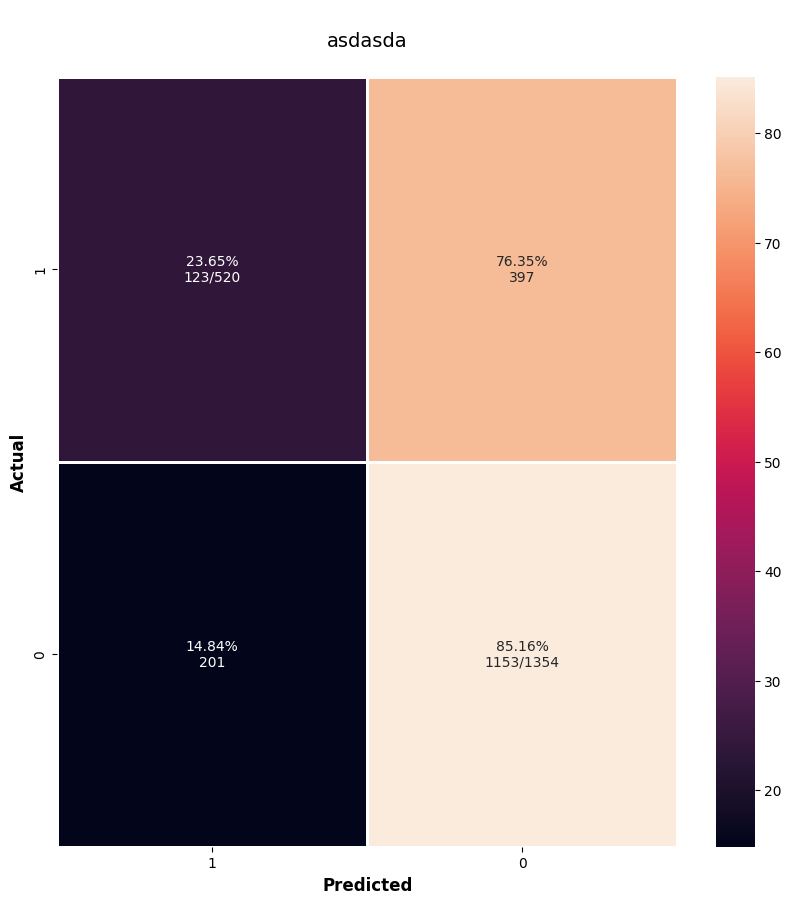

In [37]:
from sklearn.metrics import confusion_matrix

def cm_analysis(
    y_true, 
    y_pred, 
    title: str,
    filename: str, 
    labels: List[str], 
    ymap=None, 
    figsize=(10,10)
) -> None:
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.

    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      title:     plot name
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.

    Returns:
        None
    """

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    cm_perc = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm_perc.index.name = 'Actual'
    cm_perc.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm_perc, annot=annot, fmt='', linewidths=1, ax=ax)
    plt.title('\n'+title+'\n', fontsize=14)
    plt.show()


cm_analysis(y, y_pred,title='asdasda',filename='cm.png',labels=[1,0])

In [34]:
import sklearn
import scikitplot as skplt
import matplotlib.pyplot as plt

fpr_test, tpr_test, _ = sklearn.metrics.roc_curve(df_test['signal'], y_hat)
auc_test = sklearn.metrics.auc(fpr_test, tpr_test)
print(auc_test)
y_true = df_test['signal'].to_list()
y_probas = y_hat.tolist()
#skplt.metrics.plot_roc(df_test['signal'],y_probas, title=f"ROC curve, AUC=test: {auc_test:.4f}", classes_to_plot=[1], figsize=(10,10))
#plt.show()

0.5820261902056585
